In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy import stats

In [2]:
# load dark frames: dark-temp; each has 255 640x512 images
# dark40 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/-40.0C_2.496212_400.fits")
# dark35 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/-35.0C_2.496212_400.fits")
# dark30 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/-30.0C_2.4967610000000002_400.fits")
# dark25 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/-25.0C_2.4967610000000002_400.fits")
# dark20 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/-20.0C_2.4967610000000002_400.fits")
# dark15 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/-15.0C_2.4967610000000002_400.fits")
# dark10 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/-10.0C_2.4967610000000002_400.fits")
# dark5 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/-5.0C_2.4967610000000002_400.fits")
# dark0 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/0.0C_2.4967610000000002_400.fits")
############ test2 ############
dark40 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/test2/-40.0C_2.4967610000000002_400.fits")
dark35 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/test2/-35.0C_2.4967610000000002_400.fits")
dark30 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/test2/-30.0C_2.4967610000000002_400.fits")
dark25 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/test2/-25.0C_2.4967610000000002_400.fits")
dark20 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/test2/-20.0C_2.4967610000000002_400.fits")
dark15 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/test2/-15.0C_2.4967610000000002_400.fits")
dark10 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/test2/-10.0C_2.4967610000000002_400.fits")
dark5 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/test2/-5.0C_2.4967610000000002_400.fits")
dark0 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/test2/0.0C_2.4967610000000002_400.fits")
darks = [dark40, dark35, dark30, dark25, dark20, dark15, dark10, dark5, dark0]

In [3]:
# load and subtract master bias frame from dark frames
bias = np.mean(fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Bias/-40.0C_0.0028_5_dark_current_test.fits"), axis=0)
darks_subtracted = [dark - bias for dark in darks]
fits.PrimaryHDU(darks_subtracted[0]).writeto("darks_subtracted_.fits", overwrite=True)

In [4]:
# average dark frames over 255 reads:
dark_avgs = [np.mean(dark_sub, axis=0) for dark_sub in darks_subtracted]

# calculate mean pixel values at each temperature
pixel_avgs = [np.mean(dark_avg) for dark_avg in dark_avgs]

# calculate dark current = mean pixel value / exposure time
exposure_time = 2.5/1000 # all dark frames have the same exposure time (ms)
dark_current = [pixel_avg / exposure_time for pixel_avg in pixel_avgs] # list of dark currents in e-/s, sorted by temperature ascending
print(dark_current)


[62904.89317650888, 80433.36160577512, 99667.79831112135, 123813.66509172028, 152973.0082720588, 191695.70838599105, 248568.87248200065, 327107.2906565947, 452127.4399940639]


dark current increases at a rate of 8875.320553529027 ADU/s per degree Celsius


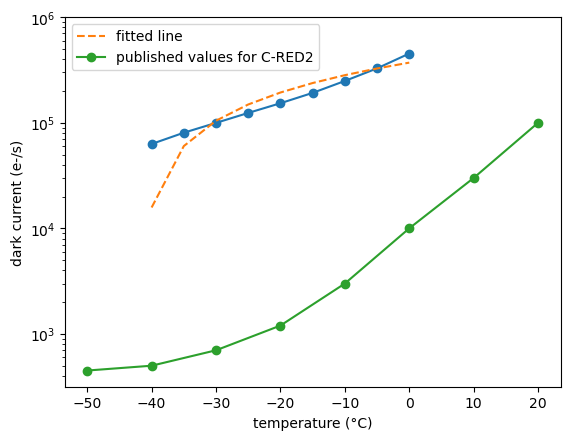

In [5]:
# plot temperature vs dark current
temp = [-40, -35, -30, -25, -20, -15, -10, -5, 0]
# gain = 0.006
# dark_current = [dc*gain for dc in dark_current] # convert to e-/s
plt.plot(temp, dark_current, '-o') # this might be in adu/s not e-/s -> find gain

# plot fitted line
coefs = np.polyfit(temp, dark_current, 1)
slope, intercept = coefs
dark_current_fit = [slope*t + intercept for t in temp]
plt.plot(temp, dark_current_fit, '--', label='fitted line')

# plot published dark current values
# these are for cred2 not cred2 er 
temp_pub = [-50, -40, -30, -20, -10, 0, 10, 20]
dark_current_pub = [450, 500, 700, 1200, 3000, 10000, 30000, 100000]
plt.plot(temp_pub, dark_current_pub, '-o', label='published values for C-RED2')

# other plot stuff
plt.ylabel('dark current (e-/s)')
plt.xlabel('temperature (°C)')
plt.yscale('log')
plt.ylim(10**2.5, 10**6)
plt.legend()

print('dark current increases at a rate of', slope, 'ADU/s per degree Celsius')

In [15]:
############################## get slope (dark current) for each temp for exposure time vs mean pixel value ############################
dark_currents = []
############### -40C ####################
# b/c previous measured dark current is so high, measure dark current again but w/ changing exposure time: dark current is supposed to increase with time
# -40C, 400 fps, tint=1, 2.5, 5, 10, 25, 50, 100, 200 ms
# darkt_point01_40 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-40.0C_0.012353_5.fits")
# darkt_point1_40 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-40.0C_0.10151500000000001_5.fits")
darkt1_40 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/-40.0C_1.00269_5_retake.fits")
darkt2_5_40 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/-40.0C_2.502526_5_retake.fits")
darkt5_40 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-40.0C_5.002251_5.fits") #retake
darkt10_40 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/-40.0C_10.001153_5_retake.fits")
darkt25_40 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/-40.0C_25.000055_5.fits")
darkt50_40 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\-40.0C_50.000493999999996_5.fits") 
darkt100_40 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/-40.0C_100.001373_5.fits")
darkt200_40 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/-40.0C_199.996761_5.fits")
darkts40 = [darkt1_40, darkt2_5_40, darkt5_40, darkt10_40, darkt25_40, darkt50_40, darkt100_40, darkt200_40]

In [16]:
def get_dark_current(darkts, bias, exposure_times): # darkts is list of darks taken at exposure_times; bias is stacked bias file; exposure_times is list of exposure times
    # subtract bias
    darkts_subtracted = [darkt - bias for darkt in darkts]

    # average dark frames over 10 reads:
    darkt_avgs = [np.mean(darkt, axis=0) for darkt in darkts_subtracted]

    # calculate mean pixel values at each tint -> tint and mean pixel value should be linearly related
    pixel_avgs_t = [np.mean(darkt_avg) for darkt_avg in darkt_avgs]

    # get fitted line coefficients
    coefs = np.polyfit(exposure_times, pixel_avgs_t, 1)
    slope, intercept = coefs

    return slope # slope is dark current 

In [17]:
# subtract bias
darkts_subtracted = [darkt - bias for darkt in darkts40]

# average dark frames over 10 reads:
darkt_avgs = [np.mean(darkt, axis=0) for darkt in darkts_subtracted]

# calculate mean pixel values at each tint -> this is the avg dark signal or dark current
pixel_avgs_t = [np.mean(darkt_avg) for darkt_avg in darkt_avgs]
print(pixel_avgs_t) # negative values are due to defective frames in original image

[5.648224182128906, 15.164535522460938, 58.62010101318358, 67.65640808105469, 209.32021118164067, 422.95755035400396, 851.8948345947267, 1804.6097793579102]


dark current is 8981.885742956696 ADU/s


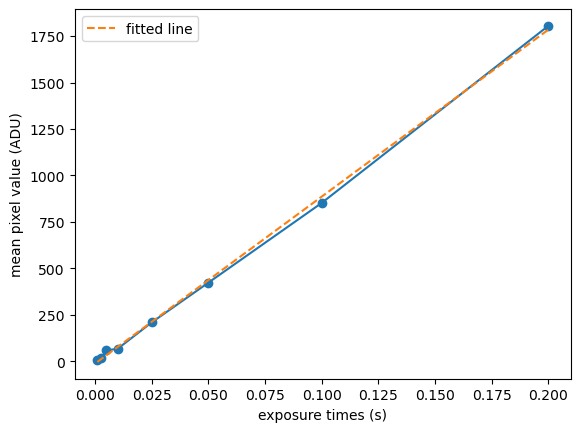

In [18]:
# plot tint vs dark current
exposure_times = [1/1000, 2.5/1000, 5/1000, 10/1000, 25/1000, 50/1000, 100/1000, 200/1000] # in s
plt.plot(exposure_times, pixel_avgs_t, '-o')

# plot fitted line
coefs = np.polyfit(exposure_times, pixel_avgs_t, 1)
slope40, intercept = coefs
dark_current_fit = [slope40*time + intercept for time in exposure_times]
plt.plot(exposure_times, dark_current_fit, '--', label='fitted line')

# other plot stuff
plt.ylabel('mean pixel value (ADU)')
plt.xlabel('exposure times (s)')

plt.legend()

print('dark current is', slope40, 'ADU/s')

In [19]:
###### -35C #########
darkt1_35 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-35.0C_1.00269_5.fits")
darkt2_5_35 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-35.0C_2.502526_5.fits")
darkt5_35 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-35.0C_5.002251_5.fits")
darkt10_35 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-35.0C_10.001702_5.fits")
darkt25_35 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-35.0C_25.000055_5.fits")
darkt50_35 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-35.0C_50.000493999999996_5.fits")
darkt100_35 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-35.0C_100.001373_5.fits")
darkt200_35 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-35.0C_199.996761_5.fits")
darkts35 = [darkt1_35, darkt2_5_35, darkt5_35, darkt10_35, darkt25_35, darkt50_35, darkt100_35, darkt200_35]
###### -30C #########
darkt1_30 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-30.0C_1.00269_5.fits")
darkt2_5_30 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-30.0C_2.502526_5.fits")
darkt5_30 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-30.0C_5.002251_5.fits")
darkt10_30 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-30.0C_10.001702_5.fits")
darkt25_30 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-30.0C_25.000055_5.fits")
darkt50_30 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-30.0C_50.000493999999996_5.fits")
darkt100_30 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-30.0C_100.001373_5.fits")
darkt200_30 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-30.0C_199.996761_5.fits")
darkts30 = [darkt1_30, darkt2_5_30, darkt5_30, darkt10_30, darkt25_30, darkt50_30, darkt100_30, darkt200_30]
####### -25C #########
darkt1_25 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-25.0C_1.00269_5.fits")
darkt2_5_25 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-25.0C_2.502526_5.fits")
darkt5_25 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-25.0C_5.002251_5.fits")
darkt10_25 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-25.0C_10.001702_5.fits")
darkt25_25 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-25.0C_25.000055_5.fits")
darkt50_25 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-25.0C_50.000493999999996_5.fits")
darkt100_25 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-25.0C_100.001373_5.fits")
darkt200_25 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-25.0C_199.996761_5.fits")
darkts25 = [darkt1_25, darkt2_5_25, darkt5_25, darkt10_25, darkt25_25, darkt50_25, darkt100_25, darkt200_25]
####### -20C #########
darkt1_20 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-20.0C_1.00269_5.fits")
darkt2_5_20 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-20.0C_2.502526_5.fits")
darkt5_20 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-20.0C_5.002251_5.fits")
darkt10_20 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-20.0C_10.001702_5.fits")
darkt25_20 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-20.0C_25.000055_5.fits")
darkt50_20 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-20.0C_50.000493999999996_5.fits")
darkt100_20 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-20.0C_100.001373_5.fits")
darkt200_20 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-20.0C_199.996761_5.fits")
darkts20 = [darkt1_20, darkt2_5_20, darkt5_20, darkt10_20, darkt25_20, darkt50_20, darkt100_20, darkt200_20]
####### -15C #########
darkt1_15 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-15.0C_1.00269_5.fits")
darkt2_5_15 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-15.0C_2.502526_5.fits")
darkt5_15 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-15.0C_5.002251_5.fits")
darkt10_15 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-15.0C_10.001702_5.fits")
darkt25_15 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-15.0C_25.000055_5.fits")
darkt50_15 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-15.0C_50.000493999999996_5.fits")
darkt100_15 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-15.0C_100.001373_5.fits")
darkt200_15 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-15.0C_199.996761_5.fits")
darkts15 = [darkt1_15, darkt2_5_15, darkt5_15, darkt10_15, darkt25_15, darkt50_15, darkt100_15, darkt200_15]
####### -10C #########
darkt1_10 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-10.0C_1.00269_5.fits")
darkt2_5_10 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-10.0C_2.502526_5.fits")
darkt5_10 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-10.0C_5.002251_5.fits")
darkt10_10 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-10.0C_10.001702_5.fits")
darkt25_10 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-10.0C_25.000055_5.fits")
darkt50_10 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-10.0C_50.000493999999996_5.fits")
darkt100_10 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-10.0C_100.001373_5.fits")
darkt200_10 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-10.0C_199.996761_5.fits")
darkts10 = [darkt1_10, darkt2_5_10, darkt5_10, darkt10_10, darkt25_10, darkt50_10, darkt100_10, darkt200_10]
####### -5C #########
darkt1_5 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-5.0C_1.00269_5.fits")
darkt2_5_5 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-5.0C_2.502526_5.fits")
darkt5_5 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-5.0C_5.002251_5.fits")
darkt10_5 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-5.0C_10.001702_5.fits")
darkt25_5 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-5.0C_25.000055_5.fits")
darkt50_5 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-5.0C_50.000493999999996_5.fits")
darkt100_5 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-5.0C_100.001373_5.fits")
darkt200_5 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-5.0C_199.996761_5.fits")
darkts5 = [darkt1_5, darkt2_5_5, darkt5_5, darkt10_5, darkt25_5, darkt50_5, darkt100_5, darkt200_5]
####### 0C #########
darkt1_0 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/dark_current_as_slope/0.0C_1.00269_5.fits")
darkt2_5_0 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/dark_current_as_slope/0.0C_2.502526_5.fits")
darkt5_0 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/dark_current_as_slope/0.0C_5.002251_5.fits")
darkt10_0 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/dark_current_as_slope/0.0C_10.001702_5.fits")
darkt25_0 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/dark_current_as_slope/0.0C_25.000055_5.fits")
darkt50_0 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/dark_current_as_slope/0.0C_50.000493999999996_5.fits")
darkt100_0 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/dark_current_as_slope/0.0C_100.001373_5.fits")
darkt200_0 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\dark_current_as_slope\-0.5C_199.996761_5.fits")
darkts0 = [darkt1_0, darkt2_5_0, darkt5_0, darkt10_0, darkt25_0, darkt50_0, darkt100_0, darkt200_0]

In [20]:
darkts = [darkts40, darkts35, darkts30, darkts25, darkts20, darkts15, darkts10, darkts5, darkts0]
dark_currents = []
for darkts_temp in darkts:
    dark_currents.append(get_dark_current(darkts_temp, bias, exposure_times))
print(dark_currents)

[8981.885742956696, 11587.957120380233, 16349.740353765728, 23182.50254541879, 32570.86435980134, 44046.65388317585, 57329.564169356025, 68112.75466376438, 74376.05007993568]


dark current increases at a rate of 53.251923321174175 ADU/s per degree Celsius


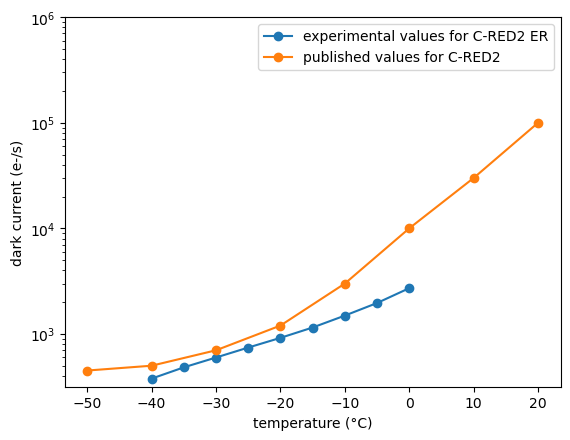

In [21]:
#### plot dark current vs temperature again ####
# plot temperature vs dark current
temp = [-40, -35, -30, -25, -20, -15, -10, -5, 0]
gain = 0.006
dark_currents = [dc*gain for dc in dark_current] # convert to e-/s
plt.plot(temp, dark_currents, '-o', label='experimental values for C-RED2 ER') # this might be in adu/s not e-/s -> find gain

# plot fitted line
coefs = np.polyfit(temp, dark_currents, 1)
slope, intercept = coefs
dark_current_fit = [slope*t + intercept for t in temp]
# plt.plot(temp, dark_current_fit, '--', label='linear fit')

# plot published dark current values
# these are for cred2 not cred2 er 
temp_pub = [-50, -40, -30, -20, -10, 0, 10, 20]
dark_current_pub = [450, 500, 700, 1200, 3000, 10000, 30000, 100000]
plt.plot(temp_pub, dark_current_pub, '-o', label='published values for C-RED2')

# other plot stuff
plt.ylabel('dark current (e-/s)')
plt.xlabel('temperature (°C)')
plt.yscale('log')
plt.ylim(10**2.5, 10**6)
plt.legend()

print('dark current increases at a rate of', slope, 'ADU/s per degree Celsius')

[29233.796107788086, 29505.32312347412, 29987.58868041992, 30183.8846572876, 30420.35926208496, 30368.552553405763, 30378.875498352052, 30089.468649902345]


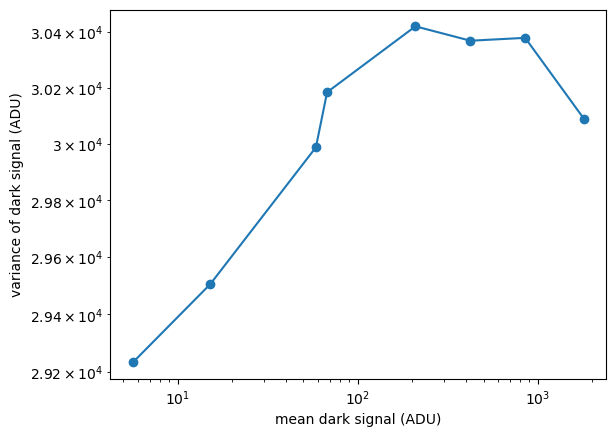

In [22]:
####################### photon transfer curve: plot mean signal by signal variance (noise) ####################### low gain

#### longer exposure times #####
# darkt25 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\photon_transfer_curve\-40.0C_25.001922_1.fits")
# darkt50 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\photon_transfer_curve\-40.0C_50.002361_1.fits")
# darkt100 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\photon_transfer_curve\-40.0C_100.000055_1.fits")
# darkt200 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\photon_transfer_curve\-40.0C_200.001812_1.fits")
# darkt300 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\photon_transfer_curve\-40.0C_300.000384_1.fits")
# darkt400 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\photon_transfer_curve\-40.0C_400.002141_1.fits")
# darkt500 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\photon_transfer_curve\-40.0C_500.000714_1.fits")
# darkt600 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\photon_transfer_curve\-40.0C_600.002471_1.fits")
# darkt700 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\photon_transfer_curve\-40.0C_700.001043_1.fits")
# darkt800 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\photon_transfer_curve\-40.0C_800.0028_1.fits")
# darkt900 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\photon_transfer_curve\-40.0C_900.0013730000001_1.fits")
# darkt1000 = fits.getdata("D:\HWP_Characterization\Data\Raw\CRED2_Characterization\Dark_Current\photon_transfer_curve\-40.0C_999.996761_1.fits")
# darkts = [darkt25, darkt50, darkt100, darkt200, darkt300, darkt400, darkt500, darkt600, darkt700, darkt800, darkt900, darkt1000]
# exposure_times = [25/1000, 50/1000, 100/1000, 200/1000, 300/1000, 400/1000, 500/1000, 600/1000, 700/1000, 800/1000, 900/1000, 1000/1000] # in s

##### subtract neighboring frames #####
mean_stds_list = []
for darkt in darkts40:
    # subtract neighboring frames for each cube; don't need to subtract bias
    subtracted = np.empty_like(darkt) # this cube contains noise or variance of dark current
    for i in range(1, darkt.shape[0]):
        subtracted[i] = darkt[i] - darkt[i-1]
    subtracted[0] = darkt[0] - darkt[1]    
    fits.PrimaryHDU(subtracted).writeto("subtracted.fits", overwrite=True)
    # find stds across frames
    #stds = np.std(subtracted, axis=0)
    # get mean of variance for each tint
    mean_std = np.mean(subtracted)
    mean_stds_list.append(mean_std)

# plot tint vs std of dark current (photon transfer curve)
    # if it's mostly flat, still in read noise regime -> take photos at longer exposure times -> it saturated :(
plt.plot(pixel_avgs_t, mean_stds_list, '-o')

# plot fitted line where slope = gain?????
# coefs = np.polyfit(exposure_times[3:8], mean_stds_list[3:8], 1)
# slope, intercept = coefs
# dark_current_fit = [slope*time + intercept for time in exposure_times[3:8]]
# plt.plot(exposure_times[3:8], dark_current_fit, '--', label='fitted line')
# print('gain:', 1/slope)

plt.ylabel('variance of dark signal (ADU)')
plt.xlabel('mean dark signal (ADU)')
plt.yscale('log')
plt.xscale('log')

print(mean_stds_list)

gain: 0.008886945116566512
[3.0987899984310294, 3.2280429977606486, 3.399159925668178, 3.865872746091219, 4.925061836307183, 6.918074435978612, 10.766383373976407, 14.814455952586064]
[5.648224182128906, 15.164535522460938, 58.62010101318358, 67.65640808105469, 209.32021118164067, 422.95755035400396, 851.8948345947267, 1804.6097793579102]


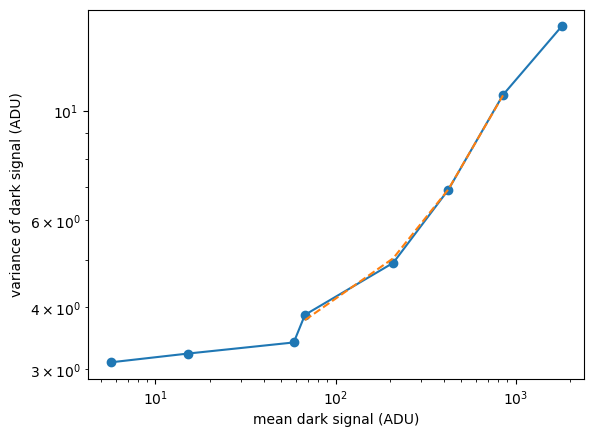

In [28]:
###### bias subtraction ######
mean_stds_list = []
# subtract bias
darkts_subtracted = [darkt - bias for darkt in darkts40]
for darkt in darkts40:
    fits.PrimaryHDU(darkt).writeto("bias_subtracted.fits", overwrite=True)
    # find stds across frames
    stds = np.std(darkt, axis=0)
    # get mean of stds for each tint
    mean_std = np.mean(stds)
    mean_stds_list.append(mean_std)

# plot mean vs std of dark current (photon transfer curve)
    # if it's mostly flat, still in read noise regime -> take photos at longer exposure times -> it saturated :(
plt.plot(pixel_avgs_t, mean_stds_list, '-o')

# plot fitted line where slope = gain?????
coefs = np.polyfit(pixel_avgs_t[3:7], mean_stds_list[3:7], 1)
slope, intercept = coefs
dark_current_fit = [slope*time + intercept for time in pixel_avgs_t[3:7]]
plt.plot(pixel_avgs_t[3:7], dark_current_fit, '--', label='fitted line')
print('gain:', slope)

plt.ylabel('variance of dark signal (ADU)')
plt.xlabel('mean dark signal (ADU)')
plt.yscale('log')
plt.xscale('log')

print(mean_stds_list)
print(pixel_avgs_t) 